In [24]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report , confusion_matrix , cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import optuna
import xgboost as xgb




In [25]:
dfTrain = pd.read_csv("train.csv")


In [26]:
dfTrain.columns

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [27]:
cols_to_drop = [
    'volatile_citric',
    'sulfur_ratio',            
    'acid_index',             
    'sweet_density',           
    'alc_density',            
    'alcohol_squared',        
    'log_sulphates',          
]


In [28]:
dfTrain.columns

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [29]:
dfTrain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15000 non-null  int64  
 1   fixed acidity         15000 non-null  float64
 2   volatile acidity      15000 non-null  float64
 3   citric acid           15000 non-null  float64
 4   residual sugar        15000 non-null  float64
 5   chlorides             15000 non-null  float64
 6   free sulfur dioxide   15000 non-null  float64
 7   total sulfur dioxide  15000 non-null  float64
 8   density               15000 non-null  float64
 9   pH                    15000 non-null  float64
 10  sulphates             15000 non-null  float64
 11  alcohol               15000 non-null  float64
 12  quality               15000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.5 MB


In [30]:
dfTrain.describe()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,8.153813,0.505495,0.231547,2.192122,0.078896,13.253967,37.32290,0.996915,3.322159,0.620184,10.190577,5.643933
std,4330.271354,1.398083,0.134842,0.176786,0.528700,0.015516,7.895505,23.95659,0.001409,0.116639,0.109148,0.899417,0.798160
min,0.000000,0.690000,0.120000,0.000000,1.080000,0.012000,1.000000,5.00000,0.990640,2.880000,0.390000,8.800000,3.000000
25%,3749.750000,7.200000,0.400000,0.050000,1.900000,0.073000,6.000000,20.00000,0.995900,3.240000,0.550000,9.500000,5.000000
50%,7499.500000,7.800000,0.500000,0.240000,2.100000,0.078000,12.000000,31.00000,0.996800,3.320000,0.600000,9.900000,6.000000
75%,11249.250000,8.900000,0.600000,0.390000,2.400000,0.084000,17.000000,48.00000,0.997800,3.390000,0.660000,10.800000,6.000000
max,14999.000000,15.900000,1.650000,0.740000,15.100000,0.415000,53.000000,165.00000,1.003690,3.780000,1.950000,14.000000,8.000000


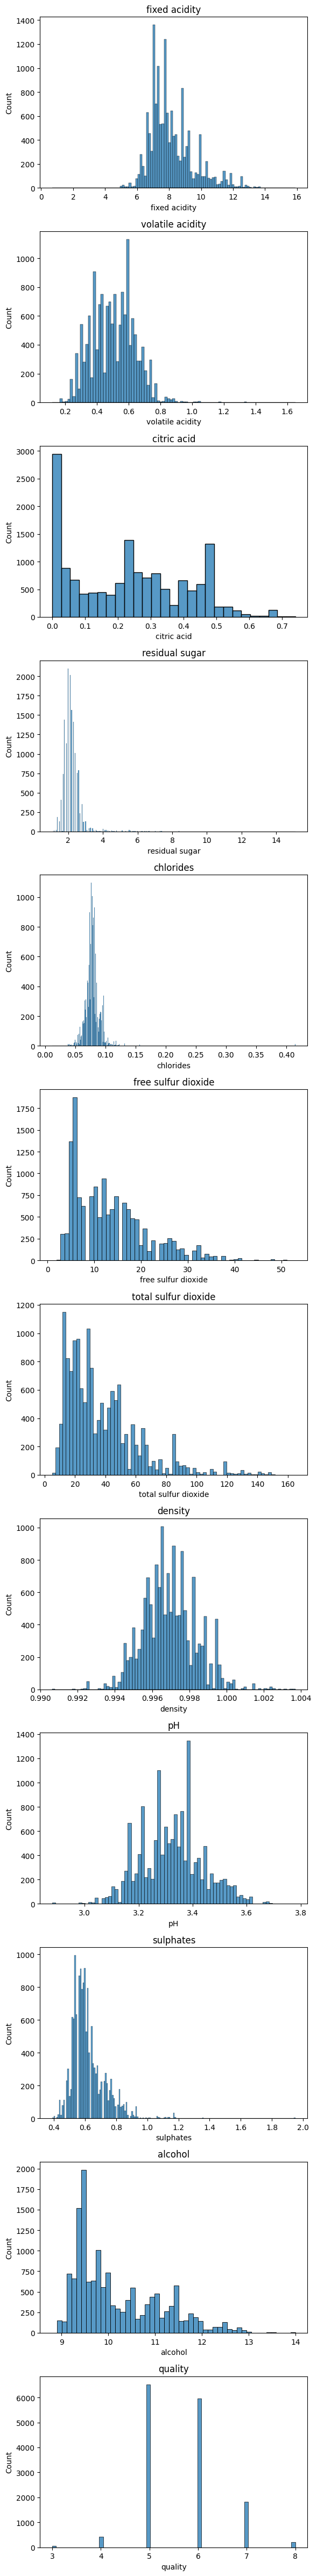

In [31]:
dfTrainNumericalCols = dfTrain.select_dtypes(include = "number")
dfTrainNumericalCols = dfTrainNumericalCols.drop(["id"], axis=1)
num_cols = len(dfTrainNumericalCols.columns)


plt.figure(figsize=(6, 4 * num_cols))

for index, column_name in enumerate(dfTrainNumericalCols.columns, start=1):
    plt.subplot(num_cols, 1, index)
    sns.histplot(dfTrainNumericalCols[column_name].dropna())
    plt.title(f'{column_name}')

plt.tight_layout()
plt.show()

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.331007     0.615570   
volatile acidity          -0.331007          1.000000    -0.655895   
citric acid                0.615570         -0.655895     1.000000   
residual sugar             0.078359         -0.044007     0.083922   
chlorides                  0.046550         -0.052797     0.074860   
free sulfur dioxide       -0.083004          0.013257    -0.019741   
total sulfur dioxide      -0.049812          0.003333     0.006607   
density                    0.252472         -0.093600     0.192762   
pH                        -0.420896          0.277847    -0.472715   
sulphates                  0.178483         -0.194117     0.238438   
alcohol                    0.025924         -0.057501     0.070175   
quality                    0.032502         -0.005916     0.021746   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity    

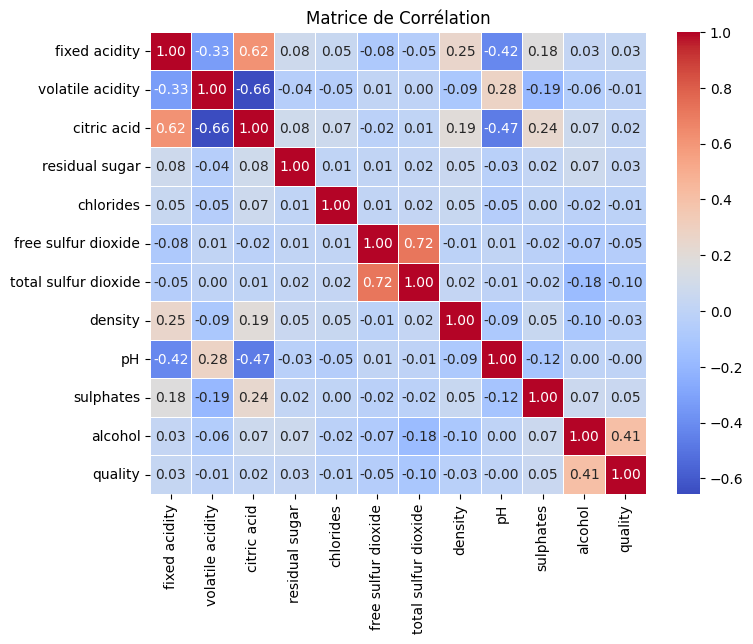

In [32]:
correlation_matrix = dfTrainNumericalCols.corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

quality
5.0    6525
6.0    5959
7.0    1824
4.0     421
8.0     203
3.0      68
Name: count, dtype: int64


<Axes: ylabel='count'>

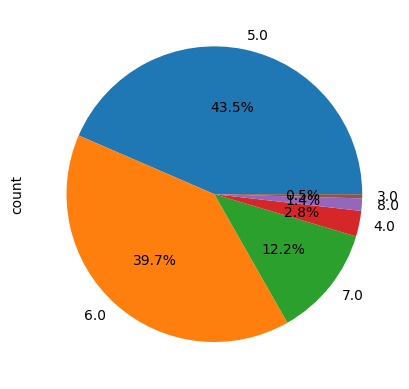

In [33]:
print(dfTrain["quality"].value_counts())

dfTrain["quality"].value_counts().plot(kind='pie',autopct='%1.1f%%')

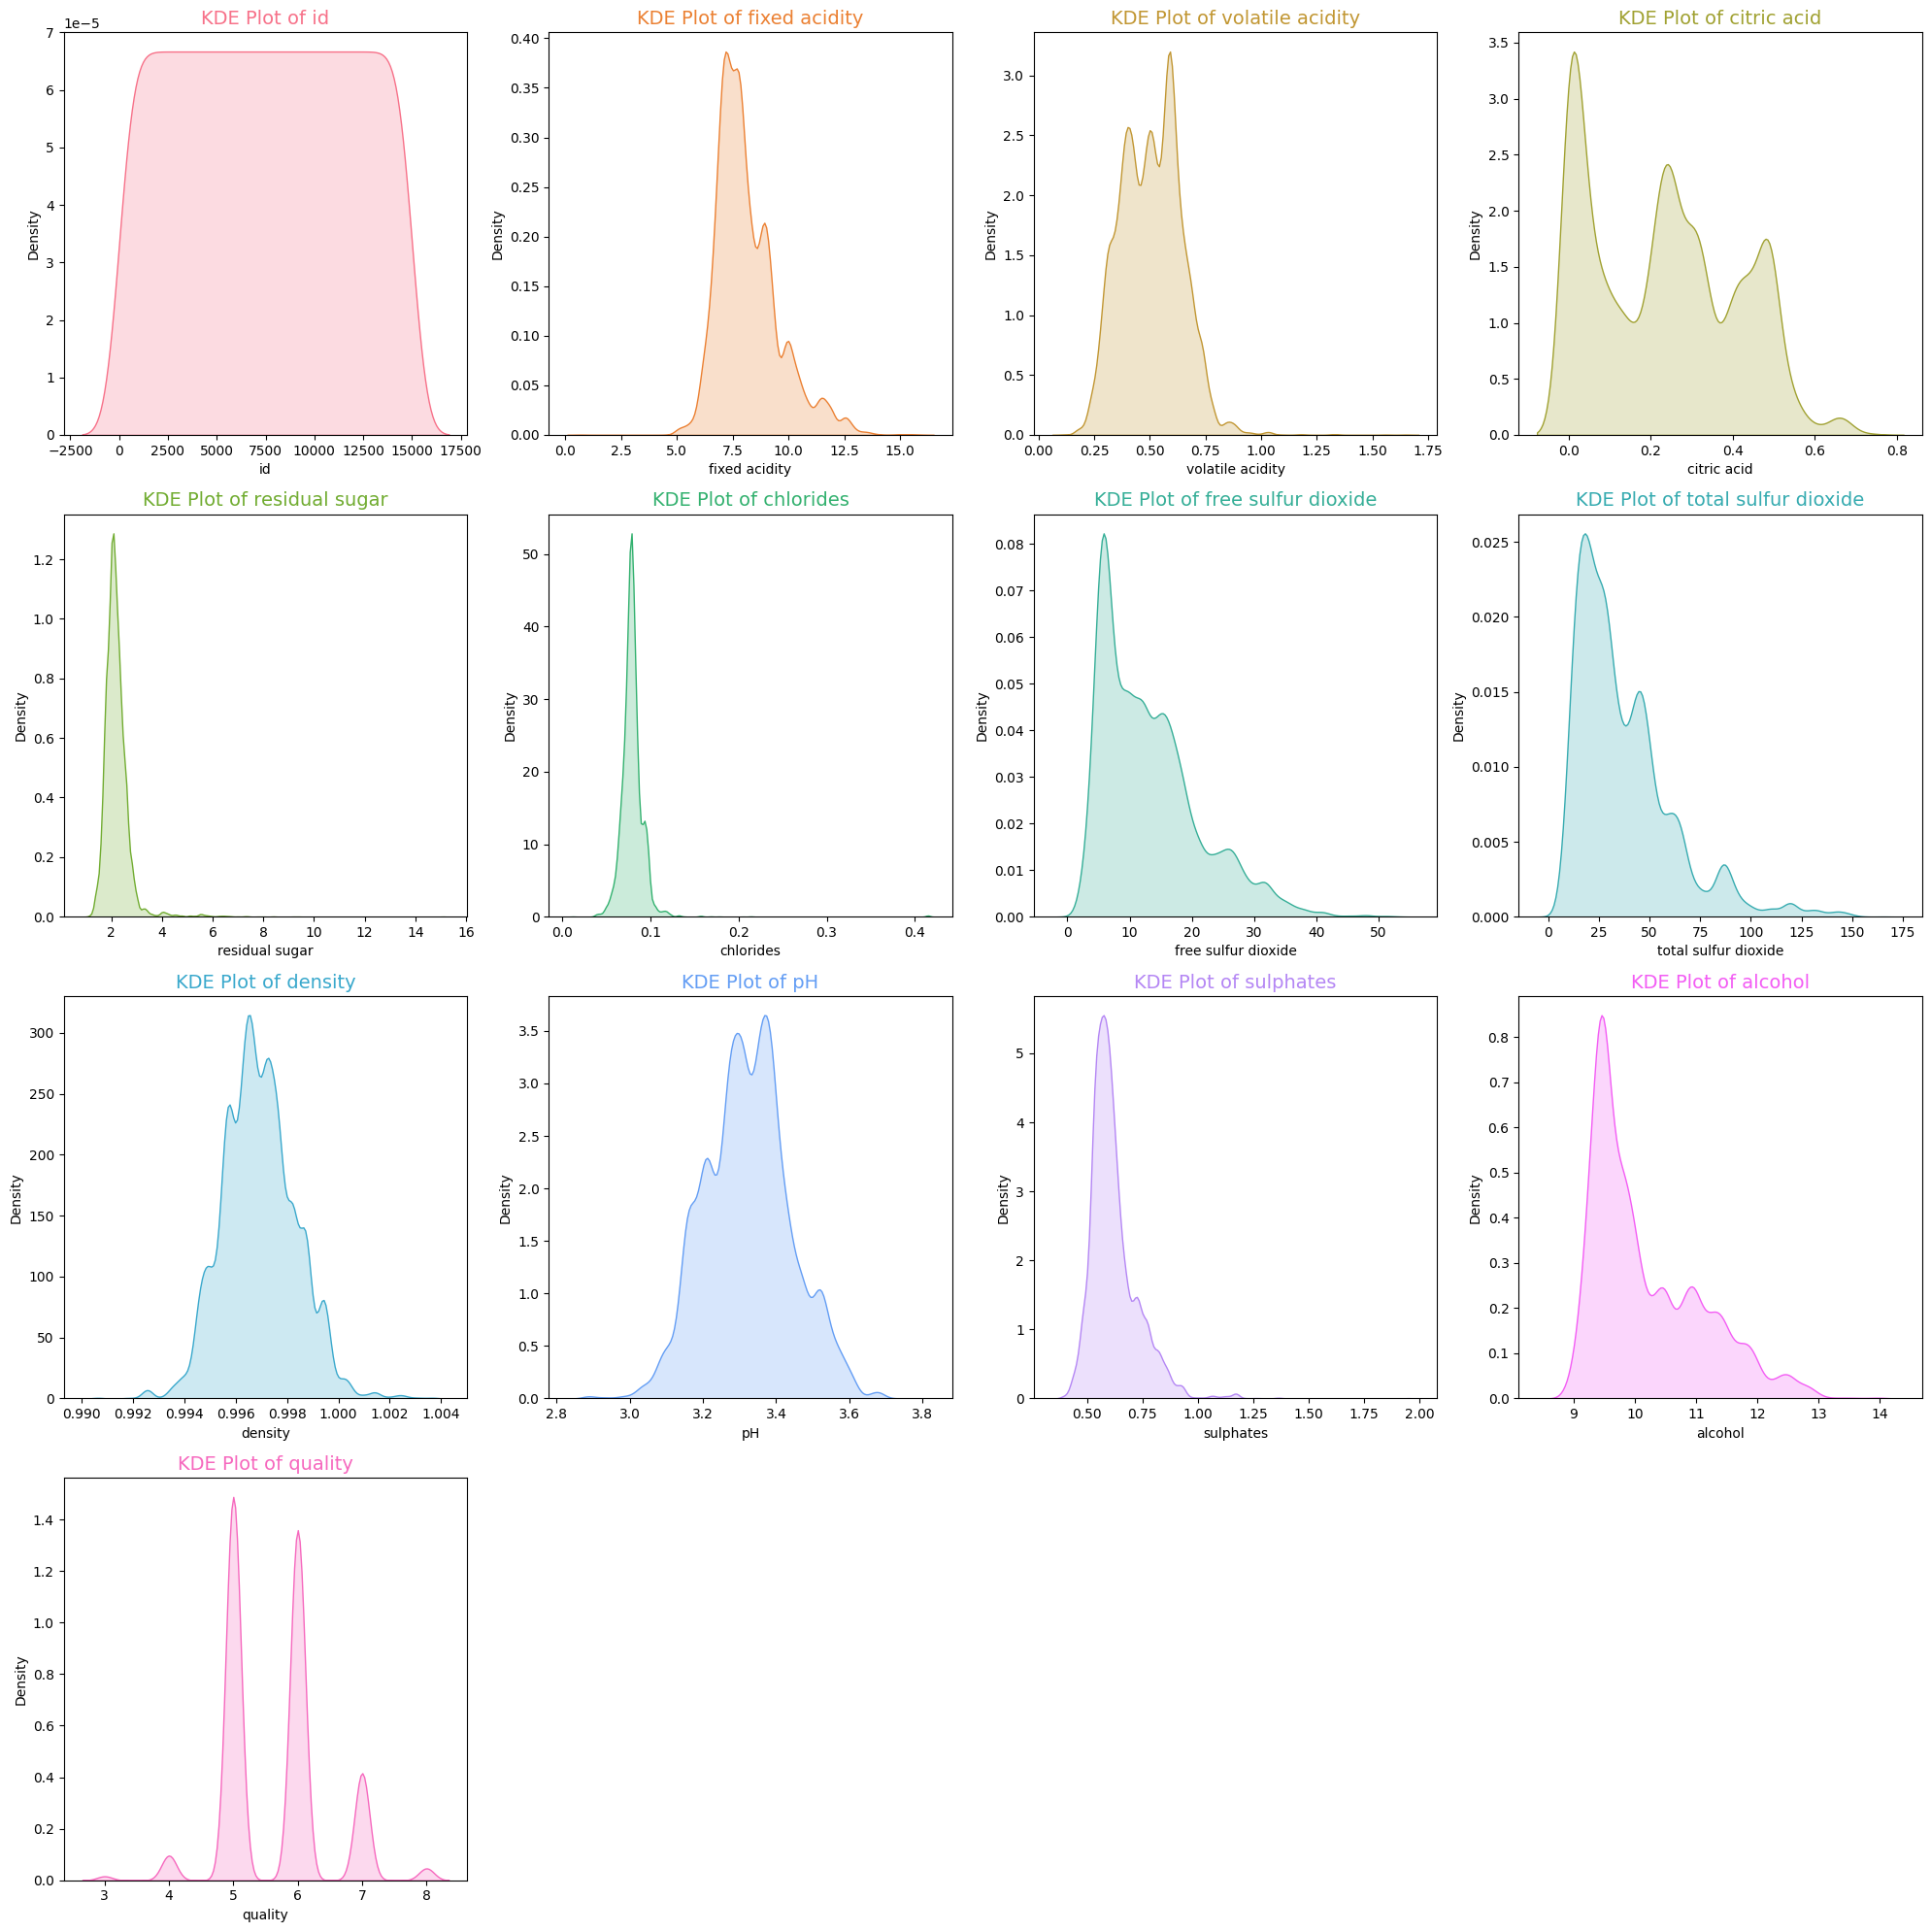

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('husl', len(dfTrain.columns))

rows = -(-len(dfTrain.columns) // 4)
plt.figure(figsize=(20, 5 * rows))

for i, (col, color) in enumerate(zip(dfTrain.columns, colors), 1):
    plt.subplot(rows, 4, i)
    sns.kdeplot(data=dfTrain, x=col, fill=True, color=color)
    plt.title(f'KDE Plot of {col}', fontsize=14, color=color)
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

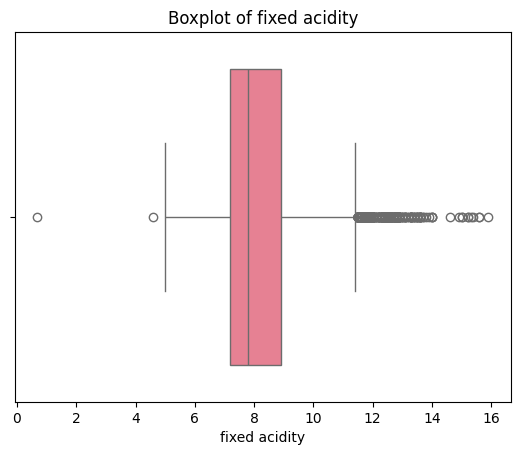

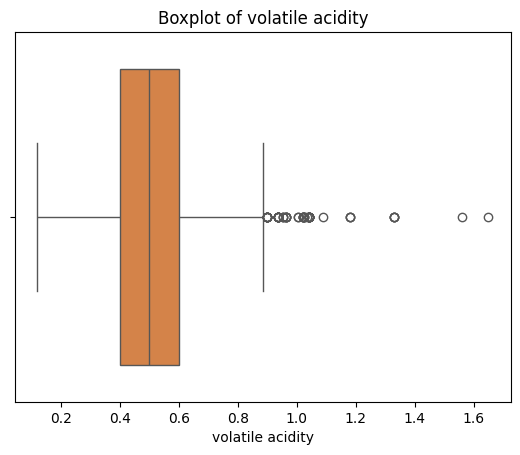

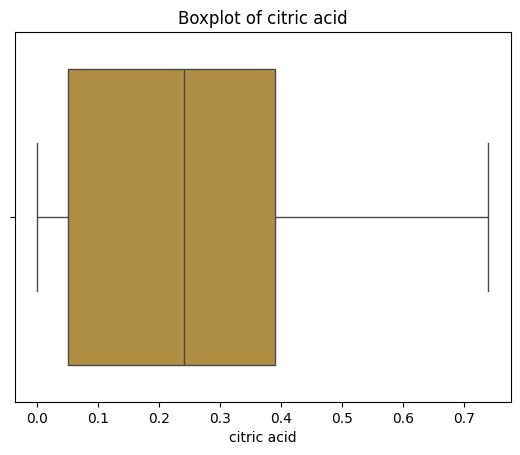

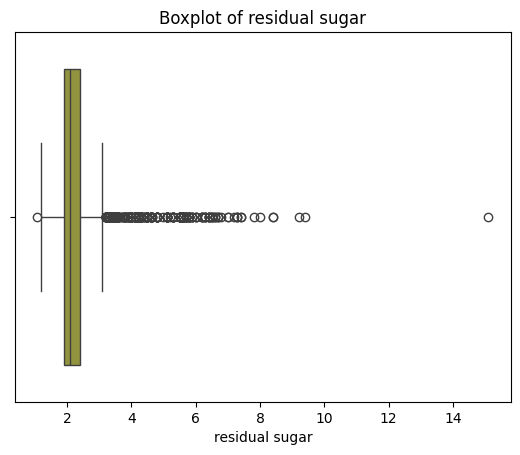

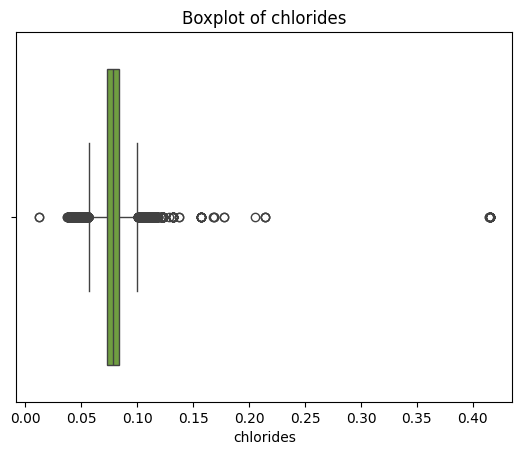

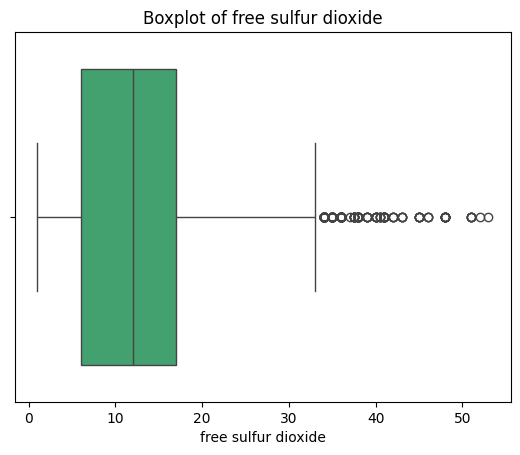

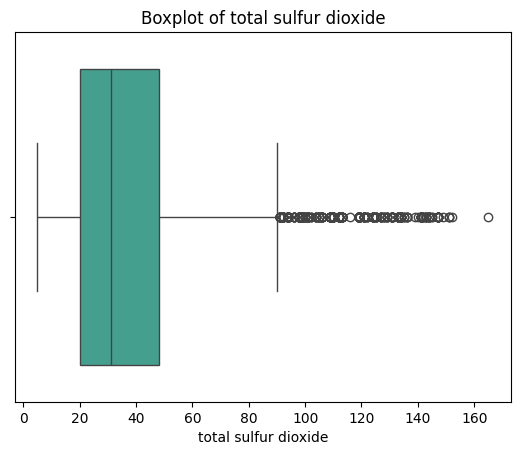

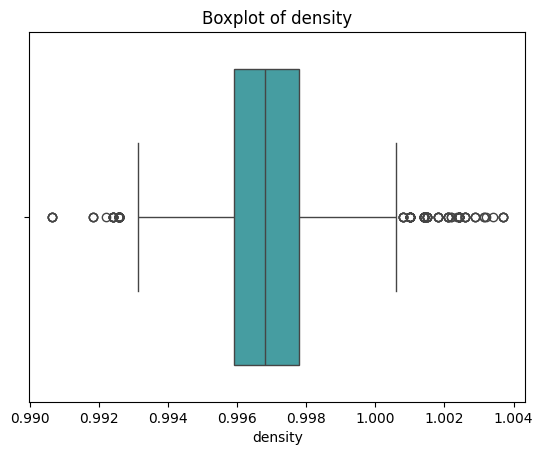

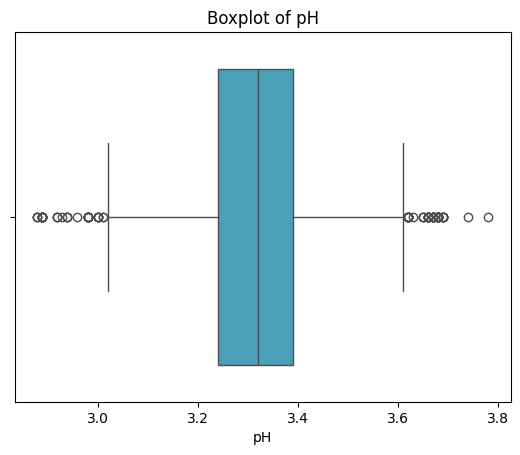

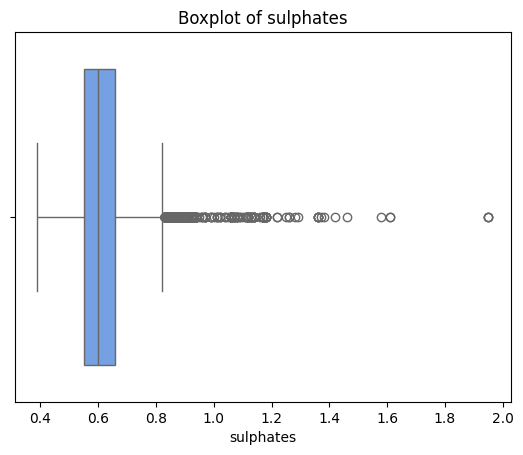

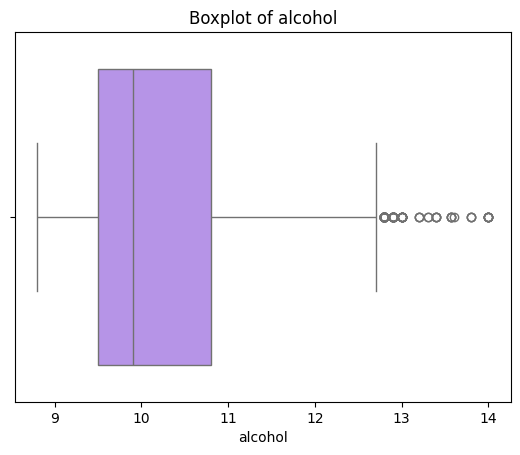

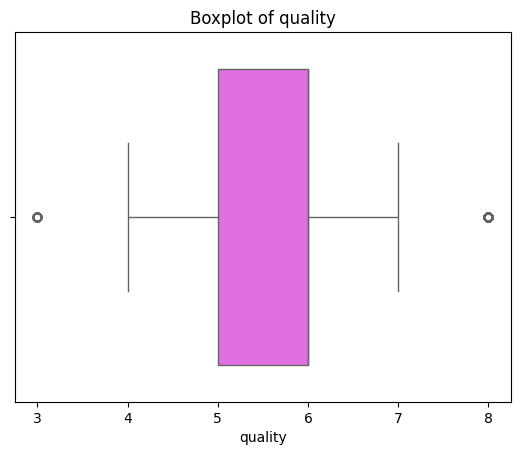

In [35]:
colors = sns.color_palette('husl', len(dfTrain.columns))

for i, col in enumerate(dfTrainNumericalCols.columns):
    sns.boxplot(x=dfTrain[col], color=colors[i]) 
    plt.title(f'Boxplot of {col}')
    plt.show()
